#### REINFORCE: Policy Gradients Algorithm implementation on CARTPOLE problem

In [1]:
# Imports
import gym
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Create solution folder
Path("solution/").mkdir(exist_ok=True)

/home/sanjeevrobosys/miniconda3/envs/rllbc_bpa2/lib/python3.9/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/home/sanjeevrobosys/miniconda3/envs/rllbc_bpa2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Take a look at the environment 
env = gym.make('CartPole-v1')
for _ in range(10):
    state, done = env.reset(), False
    while not done:
        action = env.action_space.sample()  # Random action
        state, _, done, _ = env.step(action)

        env.render()
env.close()

/home/sanjeevrobosys/miniconda3/envs/rllbc_bpa2/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


### a) Defining the Policy

In [3]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        '''In init we define the layers'''
        self.hidden1 = nn.Linear(in_features=4, out_features=128)
        self.output = nn.Linear(in_features=128, out_features=2)

    def forward(self, x):

        x = F.relu(self.hidden1(x))      # RELU non linearity
        x = self.output(x)               # final output layer
        x = F.softmax(x,dim=1)           # bcz we need prob dist over action space--> dim = 1 bcz (input is in shape=[1,4])
                                         # if input was in shape[4], then dim=0 needs to be mention                              
        return x

In [4]:
# Test code
_test_output = Policy()(torch.tensor([[1.0, 2, 3, 4]]))
assert _test_output.shape == (1, 2), f"Expected output shape (1, 2), got {_test_output.shape}"
np.testing.assert_almost_equal(_test_output.detach().numpy().sum(), 1, err_msg="Output is not a probability distribution.")
"ok"

'ok'

### b) Action Sampling

In [5]:
def sample_action(probs):
    """Sample one action from the action distribution of this state.
    
    Args:
        probs: action probabilities

    Returns:
        action: The sampled action
        log_prob: Logarithm of the probability for sampling that action
    """
    # TODO Implement action sampling
    ''' 
    used the code given under pyTorch documentation
        # Taking the list of probs (output of softmax and gives back the distribution of action space i.e action pdf)
        # Sample the distribution to get action (idx = dist.sample()) (those action will get selected who has higher probability)-->(return index value of the action)
        # Evaluate the selected action using dist.log_prob(idx) == np.log(probs[idx])
    '''
    dist = torch.distributions.Categorical(probs)           
    action = dist.sample()                         # return the idx where prob is max
    log_prob = dist.log_prob(action)
    return action.item(), log_prob

In [6]:
# Test code
_test_action, _test_log_prob = sample_action(torch.tensor([1, 2, 3, 4]))
assert _test_action in [0, 1, 2, 3], f"Invalid action {_test_action}"
np.testing.assert_approx_equal(_test_log_prob, np.log((_test_action + 1) / 10))
"ok"

'ok'

### c) Return Estimation

In [7]:
def estimate_return(rewards, gamma=0.99):

    """Estimate return based of observed rewards
    
    Args:
        rewards: Series of observed rewards
        gamma: discount factor
      
    G(t) = rt + G(t+1)
    """

    discount_rewards = np.array(rewards)  
    for step in range(len(rewards)-2,-1,-1):
        discount_rewards[step] = discount_rewards[step] + gamma*discount_rewards[step+1]
    
    ## apply standardization
    '''
    discount_rewards[0] = (discount_rewards[0] - mean) / std
    '''
    mean_value = discount_rewards.mean()
    std_value = discount_rewards.std()
    discount_rewards = (discount_rewards-mean_value)/std_value

    return torch.from_numpy(discount_rewards)

In [8]:
# Test code
np.testing.assert_array_almost_equal(
    estimate_return(np.ones(10), gamma=0.99),
    [1.54572815, 1.21139962, 0.87369404, 0.53257729, 0.18801491, -0.16002789, -0.51158628, -0.86669576, -1.22539221, -1.58771185]
)
"ok"

'ok'

### d) Training Loop

/home/sanjeevrobosys/miniconda3/envs/rllbc_bpa2/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(
Mean training reward 480.03: 100%|██████████| 1000/1000 [02:02<00:00,  8.19it/s]


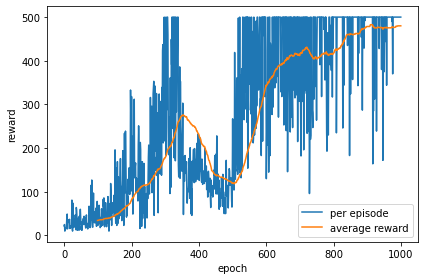

In [22]:
env = gym.make('CartPole-v1')
policy = Policy()

# Hyperparams
episodes = 1000
gamma = 0.98
learn_rate = 1.1e-3 #0.0
optimizer = torch.optim.Adam(policy.parameters(), lr=learn_rate)

total_rewards = []
with tqdm(range(episodes)) as pbar:
    for _ in pbar:
        # Run one episode
        log_probs = []
        rewards = []
        state, done = env.reset(), False
        while not done:
            # Take a step
            # ********************
            state = torch.from_numpy(state).float().unsqueeze(0)           # will return the state in torch.tensor size [1,4]
            probs = policy.forward(state)                                  # gets prob of action space
            action, log_prob = sample_action(probs)
            state, reward, done, _ = env.step(action)

            # Bookkeeping
            log_probs.append(log_prob)
            rewards.append(reward)

        total_rewards.append(sum(rewards))

        # ********************
        # Compute loss
        G = estimate_return(rewards)                 # getting the discounted reward (dtype= torch.tensor)
        policy_loss = []
        for i in range(len(log_probs)):
            policy_loss.append(-log_probs[i]*G[i])
        policy_loss = torch.cat(policy_loss).sum()
        # ********************

        # Update policy
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        # Print statistics
        pbar.set_description(f"Mean training reward {np.mean(total_rewards[-100:]):.02f}")

# Save model
with open("solution/a2d.pt", "wb") as f:
    torch.save(policy, f)

# Plot training
plt.plot(total_rewards, label="per episode")
plt.plot(pd.DataFrame(total_rewards).rolling(100).mean(), label="average reward")
plt.xlabel("epoch")
plt.ylabel("reward")
plt.legend()
plt.tight_layout()
plt.savefig("solution/a2d.png")

In [23]:
# Test code
policy.eval()  # Switch to evaluation mode


def _rollout(seed):
    env.seed(seed)
    state, done = env.reset(), False
    while not done:
        probs = policy(torch.tensor(state).float().reshape((1, -1)))[0]
        action = np.argmax(probs.detach().numpy())  # Greedy action
        state, reward, done, _ = env.step(action)
    return env._elapsed_steps


_avg_reward = np.mean([_rollout(seed=i) for i in tqdm(range(100), desc="Validating")])
assert _avg_reward >= 487.5, f"Average reward below 487.5, got {_avg_reward}"
f"ok (Average reward {_avg_reward:0.2f})"

Validating:   0%|          | 0/100 [00:00<?, ?it/s]/home/sanjeevrobosys/miniconda3/envs/rllbc_bpa2/lib/python3.9/site-packages/gym/core.py:200: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
Validating: 100%|██████████| 100/100 [00:09<00:00, 10.99it/s]


'ok (Average reward 500.00)'

In [ ]:
# Take a look at the learned policy (this will not run on the JupyterHub)
greedy = True

policy.eval()  # Switch to evaluation mode
state, done = env.reset(), False
while not done:
    probs = policy(torch.tensor(state).float().reshape((1, -1)))[0]
    if greedy:
        action = np.argmax(probs.detach().numpy())  # Chose optimal action
    else:
        action = sample_action(probs)[0]  # Sample from action distribution
    state, _, done, _ = env.step(action)
    env.render()

env.close()